In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import *

<h1 id="Use-Keras-Pretrained-Models-dataset">1. Use Keras Pretrained Models dataset<a class="anchor-link" href="#Use-Keras-Pretrained-Models-dataset" target="_self">¶</a></h1><p>Kernels can't use network connection to download pretrained keras model weights.
This dataset helps you to apply your favorite pretrained model in the Kaggle Kernel environment. 
You can find more details <a href="https://www.kaggle.com/gaborfodor/keras-pretrained-models" target="_top">here</a>.</p>
<p>We have to copy the pretrained models to the cache directory (~/.keras/models) where keras is looking for them.</p>

In [2]:
!ls ../input/inception-v3/

inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [3]:
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [4]:
!cp ../input/inception-v3/inception* ~/.keras/models/

In [5]:
!ls ~/.keras/models

inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [6]:
import matplotlib.pyplot as plt
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1
    plt.show()

# 2. Plant Seeding Code Start from here

In [7]:
x_train = []
x_test = []
y_train = []

df_test = pd.read_csv('../input/plant-seedlings-classification/sample_submission.csv')

label_map = {   "Black-grass"               :0,
                "Charlock"                  :1,
                "Cleavers"                  :2,
                "Common Chickweed"          :3,
                "Common wheat"              :4,
                "Fat Hen"                   :5,
                "Loose Silky-bent"          :6,
                "Maize"                     :7,
                "Scentless Mayweed"         :8,
                "Shepherds Purse"           :9,
                "Small-flowered Cranesbill" :10,
                "Sugar beet"                :11}

In [8]:
from glob import glob
images_per_class = {}
for class_folder_name in os.listdir("../input/plant-seedlings-classification/train/"):
    class_folder_path = os.path.join("../input/plant-seedlings-classification/train/", class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

In [9]:
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

Maize -> 221
Fat Hen -> 475
Common Chickweed -> 611
Cleavers -> 287
Charlock -> 390
Loose Silky-bent -> 654
Small-flowered Cranesbill -> 496
Black-grass -> 263
Scentless Mayweed -> 516
Sugar beet -> 385
Common wheat -> 221
Shepherds Purse -> 231


Black-grass


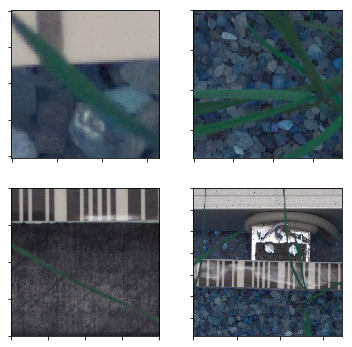

Charlock


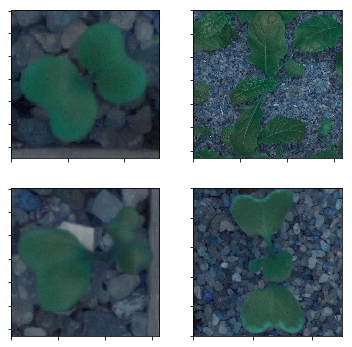

Cleavers


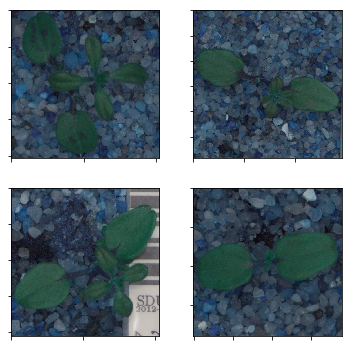

Common Chickweed


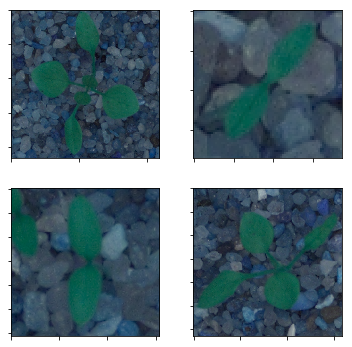

Common wheat


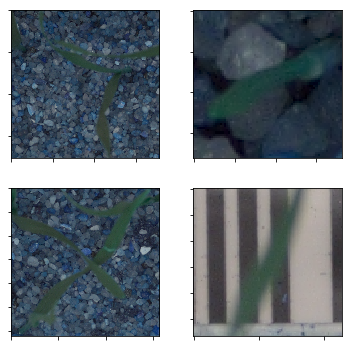

Fat Hen


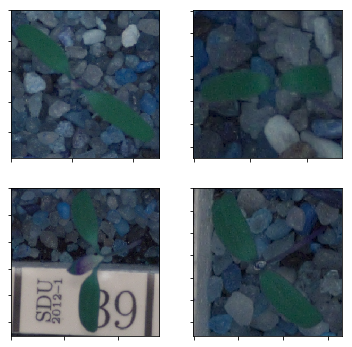

Loose Silky-bent


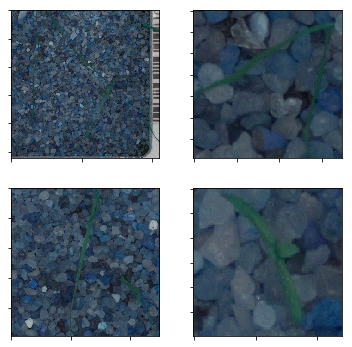

Maize


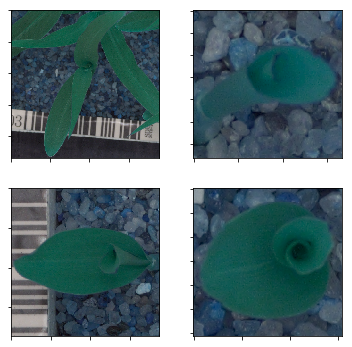

Scentless Mayweed


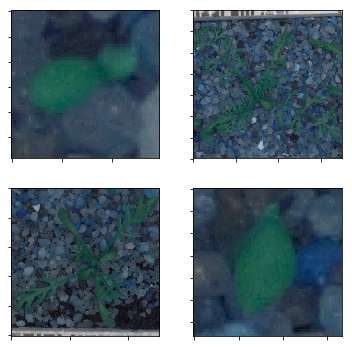

Shepherds Purse


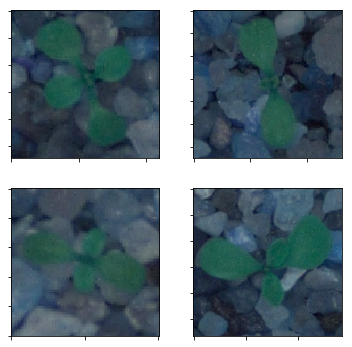

Small-flowered Cranesbill


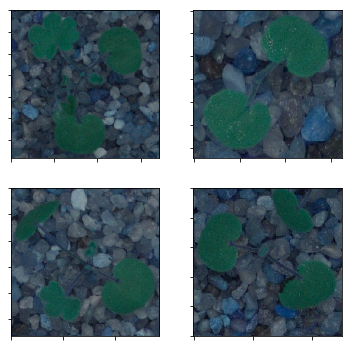

Sugar beet


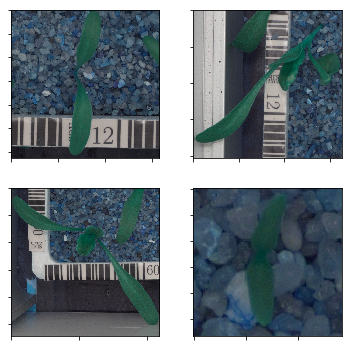

In [10]:
for label in  label_map:
    print(label)
    plot_for_class(label)

In [12]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

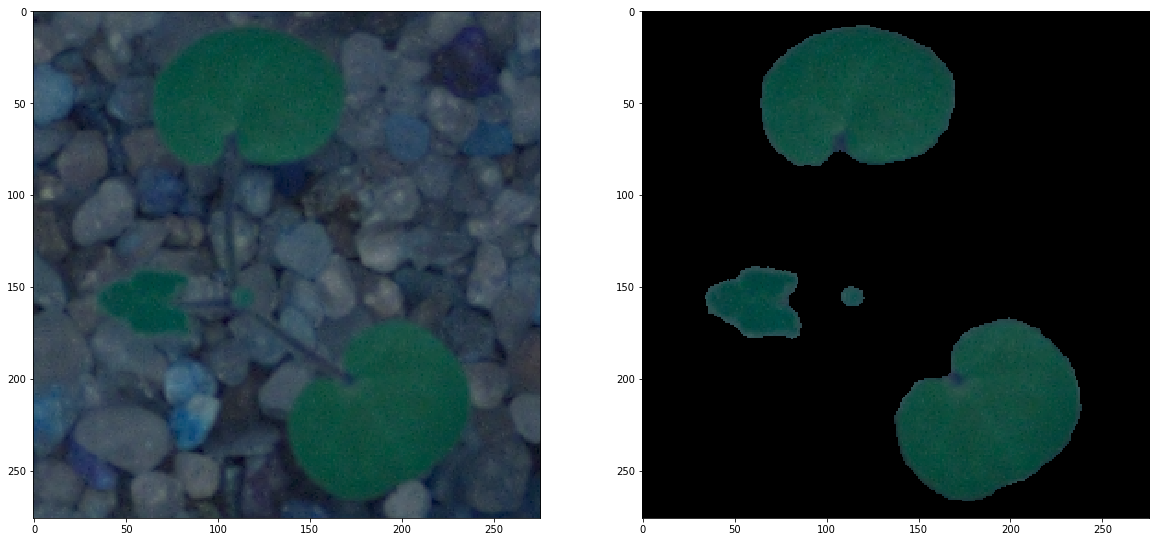

In [13]:
image = images_per_class["Small-flowered Cranesbill"][97]

image_segmented = segment_plant(image)

fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_segmented)
plt.show()

In [14]:
dim = 139

In [16]:
dirs = os.listdir("../input/plant-seedlings-classification/train/")
for k in tqdm(range(len(dirs))):    # Directory
    files = os.listdir("../input/plant-seedlings-classification/train/{}".format(dirs[k]))
    for f in range(len(files)):     # Files
        img = cv2.imread('../input/plant-seedlings-classification/train/{}/{}'.format(dirs[k], files[f]))
        targets = np.zeros(12)
        targets[label_map[dirs[k]]] = 1 
        x_train.append(cv2.resize(img, (dim, dim)))
        y_train.append(targets)

100%|██████████| 12/12 [00:39<00:00,  3.33s/it]


In [18]:
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

print(x_train.shape)
print(y_train.shape)

(4750, 139, 139, 3)
(4750, 12)


In [19]:
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.01, random_state=42)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=42) # Want a balanced split for all the classes
for train_index, test_index in sss.split(x_train, y_train):
    print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
    x_train, x_valid = x_train[train_index], x_train[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]

Using 3990 for training and 760 for validation


In [20]:
datagen = ImageDataGenerator(horizontal_flip=True, 
                              vertical_flip=True)
                                      
weights = os.path.join('', 'weightsinception3.h5')

In [21]:
epochs = 20
learning_rate = 0.0001
batch_size = 32

In [22]:
callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
              ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)]

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/callbacks.py:919: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.


In [23]:
base_model = InceptionV3(input_shape=(dim, dim, 3), include_top=False, weights='imagenet', pooling='avg') # Average pooling reduces output dimensions
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 139, 139, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 69, 69, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 69, 69, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [25]:
# ------ TRAINING ------
if os.path.isfile(weights):
    print("weight already exist")
else:
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size, 
                    validation_data=datagen.flow(x_valid, y_valid, batch_size=batch_size), 
                    validation_steps=len(x_valid)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs, 
                    verbose=1)

Epoch 1/20
125/124 [==============================] - 73s 584ms/step - loss: 1.5570 - acc: 0.5038 - val_loss: 0.7664 - val_acc: 0.7263
Epoch 2/20
125/124 [==============================] - 52s 415ms/step - loss: 0.5306 - acc: 0.8267 - val_loss: 0.3515 - val_acc: 0.8842
Epoch 3/20
125/124 [==============================] - 52s 413ms/step - loss: 0.3414 - acc: 0.8849 - val_loss: 0.3058 - val_acc: 0.8987
Epoch 4/20
125/124 [==============================] - 52s 415ms/step - loss: 0.2516 - acc: 0.9151 - val_loss: 0.2896 - val_acc: 0.9079
Epoch 5/20
125/124 [==============================] - 52s 416ms/step - loss: 0.1949 - acc: 0.9353 - val_loss: 0.2695 - val_acc: 0.9079
Epoch 6/20
125/124 [==============================] - 52s 417ms/step - loss: 0.1891 - acc: 0.9343 - val_loss: 0.2922 - val_acc: 0.9039
Epoch 7/20
125/124 [==============================] - 52s 415ms/step - loss: 0.1284 - acc: 0.9519 - val_loss: 0.3241 - val_acc: 0.8882
Epoch 8/20
125/124 [==============================] - 5

In [26]:
# ------ TESTING ------
for f, species in tqdm(df_test.values, miniters=100):
    img = cv2.imread('../input/plant-seedlings-classification/test/{}'.format(f))
    x_test.append(cv2.resize(img, (dim, dim)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

if os.path.isfile(weights):
    model.load_weights(weights)

100%|██████████| 794/794 [00:03<00:00, 214.49it/s]


(794, 139, 139, 3)


In [27]:
p_test = model.predict(x_test, verbose=1)

794/794 [==============================] - 5s 6ms/step


In [33]:
preds = []
for i in range(len(p_test)):
    pos = np.argmax(p_test[i])
    preds.append(list(label_map.keys())[list(label_map.values()).index(pos)])
    
df_test['species'] = preds
df_test.to_csv('seed_submission.csv', index=False)